# Image classification

## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

 The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')


     8192/228813984 [..............................] - ETA: 0s


  9519104/228813984 [>.............................] - ETA: 1s


 22052864/228813984 [=>............................] - ETA: 0s


 36126720/228813984 [===>..........................] - ETA: 0s


 49872896/228813984 [=====>........................] - ETA: 0s


 64651264/228813984 [=======>......................] - ETA: 0s


 79175680/228813984 [=========>....................] - ETA: 0s


 93192192/228813984 [===========>..................] - ETA: 0s


105938944/228813984 [============>.................] - ETA: 0s


118292480/228813984 [==============>...............] - ETA: 0s


131203072/228813984 [================>.............] - ETA: 0s


143941632/228813984 [=================>............] - ETA: 0s


158310400/228813984 [===================>..........] - ETA: 0s


172924928/228813984 [=====================>........] - ETA: 0s


187564032/228813984 [=======================>......] - ETA: 0s


202227712/228813984 [=========================>....] - ETA: 0s


215670784/228813984 [===========================>..] - ETA: 0s


228813984/228813984 [==============================] - 1s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

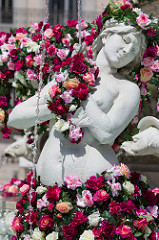

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

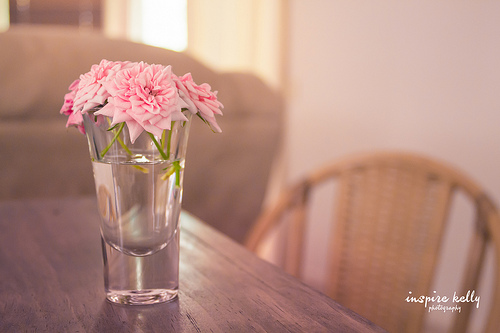

In [6]:
PIL.Image.open(str(roses[1]))

And some tulips:

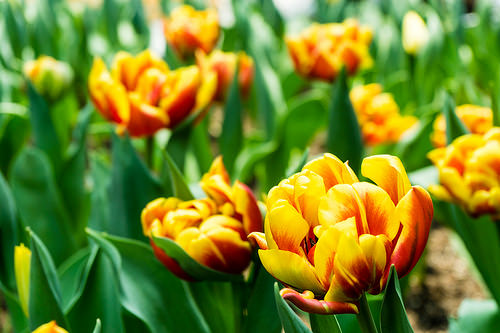

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

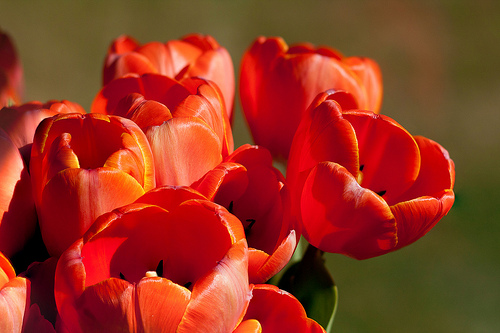

In [8]:
PIL.Image.open(str(tulips[1]))

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.


Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.


Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data



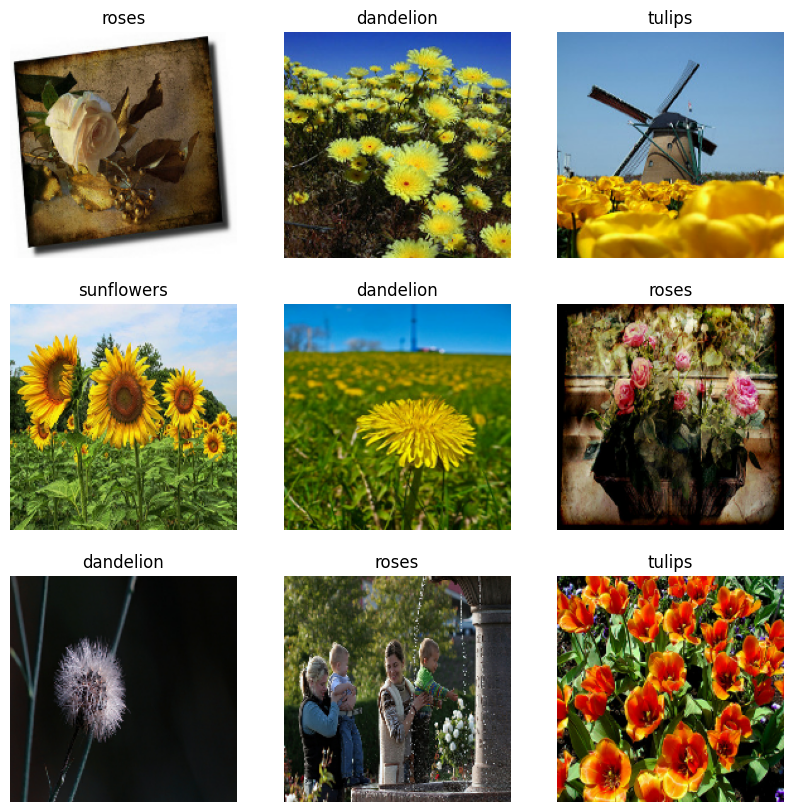

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d (Conv2D)             (None, 180, 180, 16)      448       


 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         


 D)                                                              


 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         


 g2D)                                                            


 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 64)        0         


 g2D)                                                            


 flatten (Flatten)           (None, 30976)             0         


 dense (Dense)               (None, 128)               3965056   


 dense_1 (Dense)             (None, 5)                 645       


Total params: 3989285 (15.22 MB)


Trainable params: 3989285 (15.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10



 1/92 [..............................] - ETA: 5:44 - loss: 1.5910 - accuracy: 0.3125


 5/92 [>.............................] - ETA: 1s - loss: 2.4148 - accuracy: 0.2875  


 9/92 [=>............................] - ETA: 1s - loss: 2.0724 - accuracy: 0.2535


13/92 [===>..........................] - ETA: 1s - loss: 1.9278 - accuracy: 0.2476


17/92 [====>.........................] - ETA: 1s - loss: 1.8524 - accuracy: 0.2335


21/92 [=====>........................] - ETA: 0s - loss: 1.8052 - accuracy: 0.2277


25/92 [=======>......................] - ETA: 0s - loss: 1.7716 - accuracy: 0.2313


29/92 [========>.....................] - ETA: 0s - loss: 1.7469 - accuracy: 0.2457


33/92 [=========>....................] - ETA: 0s - loss: 1.7267 - accuracy: 0.2585


37/92 [===========>..................] - ETA: 0s - loss: 1.7090 - accuracy: 0.2736


41/92 [============>.................] - ETA: 0s - loss: 1.6908 - accuracy: 0.2858


45/92 [=============>................] - ETA: 0s - loss: 1.6791 - accuracy: 0.2889


49/92 [==============>...............] - ETA: 0s - loss: 1.6690 - accuracy: 0.2857


53/92 [================>.............] - ETA: 0s - loss: 1.6558 - accuracy: 0.2889


57/92 [=================>............] - ETA: 0s - loss: 1.6429 - accuracy: 0.2922


60/92 [==================>...........] - ETA: 0s - loss: 1.6306 - accuracy: 0.3013


64/92 [===================>..........] - ETA: 0s - loss: 1.6181 - accuracy: 0.3020


68/92 [=====================>........] - ETA: 0s - loss: 1.5981 - accuracy: 0.3132


72/92 [======================>.......] - ETA: 0s - loss: 1.5825 - accuracy: 0.3193


76/92 [=======================>......] - ETA: 0s - loss: 1.5576 - accuracy: 0.3292


80/92 [=========================>....] - ETA: 0s - loss: 1.5344 - accuracy: 0.3409


84/92 [==========================>...] - ETA: 0s - loss: 1.5238 - accuracy: 0.3481


88/92 [===========================>..] - ETA: 0s - loss: 1.5095 - accuracy: 0.3543


92/92 [==============================] - ETA: 0s - loss: 1.4917 - accuracy: 0.3644


92/92 [==============================] - 6s 21ms/step - loss: 1.4917 - accuracy: 0.3644 - val_loss: 1.1232 - val_accuracy: 0.5409


Epoch 2/10



 1/92 [..............................] - ETA: 1s - loss: 1.2407 - accuracy: 0.4062


 5/92 [>.............................] - ETA: 1s - loss: 1.1378 - accuracy: 0.5188


 9/92 [=>............................] - ETA: 1s - loss: 1.0979 - accuracy: 0.5312


13/92 [===>..........................] - ETA: 1s - loss: 1.0757 - accuracy: 0.5433


17/92 [====>.........................] - ETA: 0s - loss: 1.0883 - accuracy: 0.5368


22/92 [======>.......................] - ETA: 0s - loss: 1.0703 - accuracy: 0.5560


26/92 [=======>......................] - ETA: 0s - loss: 1.0961 - accuracy: 0.5449


30/92 [========>.....................] - ETA: 0s - loss: 1.1120 - accuracy: 0.5431


34/92 [==========>...................] - ETA: 0s - loss: 1.1166 - accuracy: 0.5398


38/92 [===========>..................] - ETA: 0s - loss: 1.1182 - accuracy: 0.5455


42/92 [============>.................] - ETA: 0s - loss: 1.1092 - accuracy: 0.5509


46/92 [==============>...............] - ETA: 0s - loss: 1.1033 - accuracy: 0.5546


50/92 [===============>..............] - ETA: 0s - loss: 1.1023 - accuracy: 0.5515


54/92 [================>.............] - ETA: 0s - loss: 1.0950 - accuracy: 0.5547


58/92 [=================>............] - ETA: 0s - loss: 1.0932 - accuracy: 0.5568


62/92 [===================>..........] - ETA: 0s - loss: 1.0932 - accuracy: 0.5552


66/92 [====================>.........] - ETA: 0s - loss: 1.0869 - accuracy: 0.5575


70/92 [=====================>........] - ETA: 0s - loss: 1.0836 - accuracy: 0.5609


74/92 [=======================>......] - ETA: 0s - loss: 1.0807 - accuracy: 0.5619


78/92 [========================>.....] - ETA: 0s - loss: 1.0764 - accuracy: 0.5639


82/92 [=========================>....] - ETA: 0s - loss: 1.0704 - accuracy: 0.5696


86/92 [===========================>..] - ETA: 0s - loss: 1.0676 - accuracy: 0.5696


90/92 [============================>.] - ETA: 0s - loss: 1.0614 - accuracy: 0.5731


92/92 [==============================] - 1s 15ms/step - loss: 1.0611 - accuracy: 0.5743 - val_loss: 1.0191 - val_accuracy: 0.5858


Epoch 3/10



 1/92 [..............................] - ETA: 1s - loss: 0.9592 - accuracy: 0.5938


 5/92 [>.............................] - ETA: 1s - loss: 1.0525 - accuracy: 0.6438


 9/92 [=>............................] - ETA: 1s - loss: 0.9956 - accuracy: 0.6493


13/92 [===>..........................] - ETA: 1s - loss: 1.0058 - accuracy: 0.6346


17/92 [====>.........................] - ETA: 0s - loss: 0.9895 - accuracy: 0.6397


21/92 [=====>........................] - ETA: 0s - loss: 1.0030 - accuracy: 0.6235


25/92 [=======>......................] - ETA: 0s - loss: 1.0120 - accuracy: 0.6200


29/92 [========>.....................] - ETA: 0s - loss: 1.0037 - accuracy: 0.6315


33/92 [=========>....................] - ETA: 0s - loss: 0.9692 - accuracy: 0.6458


37/92 [===========>..................] - ETA: 0s - loss: 0.9580 - accuracy: 0.6520


41/92 [============>.................] - ETA: 0s - loss: 0.9417 - accuracy: 0.6540


45/92 [=============>................] - ETA: 0s - loss: 0.9428 - accuracy: 0.6535


49/92 [==============>...............] - ETA: 0s - loss: 0.9439 - accuracy: 0.6531


53/92 [================>.............] - ETA: 0s - loss: 0.9354 - accuracy: 0.6545


57/92 [=================>............] - ETA: 0s - loss: 0.9295 - accuracy: 0.6546


62/92 [===================>..........] - ETA: 0s - loss: 0.9190 - accuracy: 0.6574


66/92 [====================>.........] - ETA: 0s - loss: 0.9148 - accuracy: 0.6611


70/92 [=====================>........] - ETA: 0s - loss: 0.9073 - accuracy: 0.6631


74/92 [=======================>......] - ETA: 0s - loss: 0.8996 - accuracy: 0.6657


78/92 [========================>.....] - ETA: 0s - loss: 0.8895 - accuracy: 0.6688


82/92 [=========================>....] - ETA: 0s - loss: 0.8852 - accuracy: 0.6697


86/92 [===========================>..] - ETA: 0s - loss: 0.8855 - accuracy: 0.6695


90/92 [============================>.] - ETA: 0s - loss: 0.8844 - accuracy: 0.6692


92/92 [==============================] - 1s 15ms/step - loss: 0.8832 - accuracy: 0.6686 - val_loss: 1.0277 - val_accuracy: 0.5736


Epoch 4/10



 1/92 [..............................] - ETA: 1s - loss: 0.8354 - accuracy: 0.6875


 5/92 [>.............................] - ETA: 1s - loss: 0.7879 - accuracy: 0.7500


 9/92 [=>............................] - ETA: 1s - loss: 0.7360 - accuracy: 0.7500


13/92 [===>..........................] - ETA: 1s - loss: 0.7375 - accuracy: 0.7428


17/92 [====>.........................] - ETA: 0s - loss: 0.7351 - accuracy: 0.7518


21/92 [=====>........................] - ETA: 0s - loss: 0.7418 - accuracy: 0.7426


25/92 [=======>......................] - ETA: 0s - loss: 0.7177 - accuracy: 0.7475


29/92 [========>.....................] - ETA: 0s - loss: 0.7410 - accuracy: 0.7392


33/92 [=========>....................] - ETA: 0s - loss: 0.7396 - accuracy: 0.7415


37/92 [===========>..................] - ETA: 0s - loss: 0.7414 - accuracy: 0.7382


41/92 [============>.................] - ETA: 0s - loss: 0.7383 - accuracy: 0.7370


45/92 [=============>................] - ETA: 0s - loss: 0.7263 - accuracy: 0.7403


49/92 [==============>...............] - ETA: 0s - loss: 0.7179 - accuracy: 0.7417


53/92 [================>.............] - ETA: 0s - loss: 0.7091 - accuracy: 0.7488


57/92 [=================>............] - ETA: 0s - loss: 0.7028 - accuracy: 0.7522


61/92 [==================>...........] - ETA: 0s - loss: 0.7022 - accuracy: 0.7500


65/92 [====================>.........] - ETA: 0s - loss: 0.7041 - accuracy: 0.7486


69/92 [=====================>........] - ETA: 0s - loss: 0.7074 - accuracy: 0.7450


73/92 [======================>.......] - ETA: 0s - loss: 0.7054 - accuracy: 0.7449


77/92 [========================>.....] - ETA: 0s - loss: 0.6980 - accuracy: 0.7476


82/92 [=========================>....] - ETA: 0s - loss: 0.6969 - accuracy: 0.7477


86/92 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.7493


90/92 [============================>.] - ETA: 0s - loss: 0.6921 - accuracy: 0.7483


92/92 [==============================] - 1s 15ms/step - loss: 0.6891 - accuracy: 0.7493 - val_loss: 0.9515 - val_accuracy: 0.6335


Epoch 5/10



 1/92 [..............................] - ETA: 1s - loss: 0.5885 - accuracy: 0.7812


 5/92 [>.............................] - ETA: 1s - loss: 0.5396 - accuracy: 0.7812


 9/92 [=>............................] - ETA: 1s - loss: 0.5682 - accuracy: 0.7812


13/92 [===>..........................] - ETA: 1s - loss: 0.5631 - accuracy: 0.7812


17/92 [====>.........................] - ETA: 0s - loss: 0.5506 - accuracy: 0.7904


21/92 [=====>........................] - ETA: 0s - loss: 0.5407 - accuracy: 0.8006


25/92 [=======>......................] - ETA: 0s - loss: 0.5278 - accuracy: 0.8075


29/92 [========>.....................] - ETA: 0s - loss: 0.5173 - accuracy: 0.8103


33/92 [=========>....................] - ETA: 0s - loss: 0.5049 - accuracy: 0.8163


37/92 [===========>..................] - ETA: 0s - loss: 0.5094 - accuracy: 0.8176


41/92 [============>.................] - ETA: 0s - loss: 0.5047 - accuracy: 0.8201


45/92 [=============>................] - ETA: 0s - loss: 0.5046 - accuracy: 0.8219


49/92 [==============>...............] - ETA: 0s - loss: 0.5129 - accuracy: 0.8147


53/92 [================>.............] - ETA: 0s - loss: 0.5032 - accuracy: 0.8187


57/92 [=================>............] - ETA: 0s - loss: 0.5021 - accuracy: 0.8177


61/92 [==================>...........] - ETA: 0s - loss: 0.4994 - accuracy: 0.8189


65/92 [====================>.........] - ETA: 0s - loss: 0.5024 - accuracy: 0.8185


69/92 [=====================>........] - ETA: 0s - loss: 0.4961 - accuracy: 0.8223


73/92 [======================>.......] - ETA: 0s - loss: 0.4965 - accuracy: 0.8209


77/92 [========================>.....] - ETA: 0s - loss: 0.4950 - accuracy: 0.8204


81/92 [=========================>....] - ETA: 0s - loss: 0.4958 - accuracy: 0.8204


85/92 [==========================>...] - ETA: 0s - loss: 0.4946 - accuracy: 0.8204


89/92 [============================>.] - ETA: 0s - loss: 0.4944 - accuracy: 0.8204


92/92 [==============================] - 1s 15ms/step - loss: 0.4928 - accuracy: 0.8208 - val_loss: 0.9375 - val_accuracy: 0.6717


Epoch 6/10



 1/92 [..............................] - ETA: 1s - loss: 0.2843 - accuracy: 0.9062


 5/92 [>.............................] - ETA: 1s - loss: 0.3341 - accuracy: 0.9125


 9/92 [=>............................] - ETA: 1s - loss: 0.3099 - accuracy: 0.9201


13/92 [===>..........................] - ETA: 1s - loss: 0.3193 - accuracy: 0.9135


17/92 [====>.........................] - ETA: 0s - loss: 0.3370 - accuracy: 0.9007


21/92 [=====>........................] - ETA: 0s - loss: 0.3283 - accuracy: 0.9018


25/92 [=======>......................] - ETA: 0s - loss: 0.3341 - accuracy: 0.9000


29/92 [========>.....................] - ETA: 0s - loss: 0.3261 - accuracy: 0.9019


33/92 [=========>....................] - ETA: 0s - loss: 0.3173 - accuracy: 0.9053


37/92 [===========>..................] - ETA: 0s - loss: 0.3129 - accuracy: 0.9062


41/92 [============>.................] - ETA: 0s - loss: 0.3170 - accuracy: 0.9009


45/92 [=============>................] - ETA: 0s - loss: 0.3208 - accuracy: 0.8979


49/92 [==============>...............] - ETA: 0s - loss: 0.3227 - accuracy: 0.8986


53/92 [================>.............] - ETA: 0s - loss: 0.3240 - accuracy: 0.8992


57/92 [=================>............] - ETA: 0s - loss: 0.3300 - accuracy: 0.8942


61/92 [==================>...........] - ETA: 0s - loss: 0.3328 - accuracy: 0.8924


65/92 [====================>.........] - ETA: 0s - loss: 0.3335 - accuracy: 0.8909


69/92 [=====================>........] - ETA: 0s - loss: 0.3278 - accuracy: 0.8932


73/92 [======================>.......] - ETA: 0s - loss: 0.3256 - accuracy: 0.8930


77/92 [========================>.....] - ETA: 0s - loss: 0.3261 - accuracy: 0.8917


81/92 [=========================>....] - ETA: 0s - loss: 0.3215 - accuracy: 0.8940


85/92 [==========================>...] - ETA: 0s - loss: 0.3181 - accuracy: 0.8953


89/92 [============================>.] - ETA: 0s - loss: 0.3229 - accuracy: 0.8933


92/92 [==============================] - 1s 15ms/step - loss: 0.3269 - accuracy: 0.8907 - val_loss: 1.0892 - val_accuracy: 0.6131


Epoch 7/10



 1/92 [..............................] - ETA: 1s - loss: 0.3368 - accuracy: 0.8750


 5/92 [>.............................] - ETA: 1s - loss: 0.2800 - accuracy: 0.9312


 9/92 [=>............................] - ETA: 1s - loss: 0.2378 - accuracy: 0.9514


13/92 [===>..........................] - ETA: 1s - loss: 0.2391 - accuracy: 0.9495


17/92 [====>.........................] - ETA: 0s - loss: 0.2300 - accuracy: 0.9504


21/92 [=====>........................] - ETA: 0s - loss: 0.2088 - accuracy: 0.9524


25/92 [=======>......................] - ETA: 0s - loss: 0.2148 - accuracy: 0.9463


29/92 [========>.....................] - ETA: 0s - loss: 0.2124 - accuracy: 0.9450


33/92 [=========>....................] - ETA: 0s - loss: 0.2095 - accuracy: 0.9432


37/92 [===========>..................] - ETA: 0s - loss: 0.2086 - accuracy: 0.9405


41/92 [============>.................] - ETA: 0s - loss: 0.2034 - accuracy: 0.9417


45/92 [=============>................] - ETA: 0s - loss: 0.2045 - accuracy: 0.9420


49/92 [==============>...............] - ETA: 0s - loss: 0.2004 - accuracy: 0.9429


53/92 [================>.............] - ETA: 0s - loss: 0.1980 - accuracy: 0.9431


57/92 [=================>............] - ETA: 0s - loss: 0.1963 - accuracy: 0.9438


61/92 [==================>...........] - ETA: 0s - loss: 0.1976 - accuracy: 0.9398


65/92 [====================>.........] - ETA: 0s - loss: 0.1998 - accuracy: 0.9387


69/92 [=====================>........] - ETA: 0s - loss: 0.1971 - accuracy: 0.9395


73/92 [======================>.......] - ETA: 0s - loss: 0.1972 - accuracy: 0.9386


77/92 [========================>.....] - ETA: 0s - loss: 0.1960 - accuracy: 0.9377


81/92 [=========================>....] - ETA: 0s - loss: 0.1942 - accuracy: 0.9381


85/92 [==========================>...] - ETA: 0s - loss: 0.1954 - accuracy: 0.9384


89/92 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9387


92/92 [==============================] - 1s 15ms/step - loss: 0.1947 - accuracy: 0.9390 - val_loss: 1.3664 - val_accuracy: 0.6431


Epoch 8/10



 1/92 [..............................] - ETA: 1s - loss: 0.0504 - accuracy: 1.0000


 5/92 [>.............................] - ETA: 1s - loss: 0.0883 - accuracy: 0.9750


 9/92 [=>............................] - ETA: 1s - loss: 0.1029 - accuracy: 0.9757


13/92 [===>..........................] - ETA: 1s - loss: 0.0940 - accuracy: 0.9784


17/92 [====>.........................] - ETA: 0s - loss: 0.0963 - accuracy: 0.9757


21/92 [=====>........................] - ETA: 0s - loss: 0.0929 - accuracy: 0.9744


25/92 [=======>......................] - ETA: 0s - loss: 0.0976 - accuracy: 0.9735


29/92 [========>.....................] - ETA: 0s - loss: 0.0959 - accuracy: 0.9728


33/92 [=========>....................] - ETA: 0s - loss: 0.0934 - accuracy: 0.9742


37/92 [===========>..................] - ETA: 0s - loss: 0.0928 - accuracy: 0.9753


41/92 [============>.................] - ETA: 0s - loss: 0.0926 - accuracy: 0.9755


45/92 [=============>................] - ETA: 0s - loss: 0.0888 - accuracy: 0.9770


49/92 [==============>...............] - ETA: 0s - loss: 0.0880 - accuracy: 0.9769


53/92 [================>.............] - ETA: 0s - loss: 0.0853 - accuracy: 0.9781


57/92 [=================>............] - ETA: 0s - loss: 0.0853 - accuracy: 0.9780


61/92 [==================>...........] - ETA: 0s - loss: 0.0847 - accuracy: 0.9784


65/92 [====================>.........] - ETA: 0s - loss: 0.0867 - accuracy: 0.9783


69/92 [=====================>........] - ETA: 0s - loss: 0.0850 - accuracy: 0.9791


73/92 [======================>.......] - ETA: 0s - loss: 0.0874 - accuracy: 0.9785


77/92 [========================>.....] - ETA: 0s - loss: 0.0906 - accuracy: 0.9780


81/92 [=========================>....] - ETA: 0s - loss: 0.0901 - accuracy: 0.9779


85/92 [==========================>...] - ETA: 0s - loss: 0.0925 - accuracy: 0.9771


89/92 [============================>.] - ETA: 0s - loss: 0.0909 - accuracy: 0.9778


92/92 [==============================] - 1s 15ms/step - loss: 0.0929 - accuracy: 0.9772 - val_loss: 1.5312 - val_accuracy: 0.6172


Epoch 9/10



 1/92 [..............................] - ETA: 1s - loss: 0.0783 - accuracy: 1.0000


 5/92 [>.............................] - ETA: 1s - loss: 0.0541 - accuracy: 0.9937


 9/92 [=>............................] - ETA: 1s - loss: 0.0592 - accuracy: 0.9896


13/92 [===>..........................] - ETA: 1s - loss: 0.0584 - accuracy: 0.9880


17/92 [====>.........................] - ETA: 0s - loss: 0.0517 - accuracy: 0.9908


21/92 [=====>........................] - ETA: 0s - loss: 0.0472 - accuracy: 0.9911


25/92 [=======>......................] - ETA: 0s - loss: 0.0442 - accuracy: 0.9912


29/92 [========>.....................] - ETA: 0s - loss: 0.0429 - accuracy: 0.9925


33/92 [=========>....................] - ETA: 0s - loss: 0.0408 - accuracy: 0.9924


37/92 [===========>..................] - ETA: 0s - loss: 0.0421 - accuracy: 0.9916


41/92 [============>.................] - ETA: 0s - loss: 0.0415 - accuracy: 0.9916


45/92 [=============>................] - ETA: 0s - loss: 0.0412 - accuracy: 0.9917


49/92 [==============>...............] - ETA: 0s - loss: 0.0413 - accuracy: 0.9917


53/92 [================>.............] - ETA: 0s - loss: 0.0413 - accuracy: 0.9917


57/92 [=================>............] - ETA: 0s - loss: 0.0429 - accuracy: 0.9912


61/92 [==================>...........] - ETA: 0s - loss: 0.0444 - accuracy: 0.9902


65/92 [====================>.........] - ETA: 0s - loss: 0.0442 - accuracy: 0.9903


69/92 [=====================>........] - ETA: 0s - loss: 0.0456 - accuracy: 0.9900


73/92 [======================>.......] - ETA: 0s - loss: 0.0476 - accuracy: 0.9897


77/92 [========================>.....] - ETA: 0s - loss: 0.0483 - accuracy: 0.9894


81/92 [=========================>....] - ETA: 0s - loss: 0.0471 - accuracy: 0.9899


85/92 [==========================>...] - ETA: 0s - loss: 0.0466 - accuracy: 0.9897


89/92 [============================>.] - ETA: 0s - loss: 0.0472 - accuracy: 0.9898


92/92 [==============================] - 1s 15ms/step - loss: 0.0480 - accuracy: 0.9898 - val_loss: 1.7783 - val_accuracy: 0.6608


Epoch 10/10



 1/92 [..............................] - ETA: 1s - loss: 0.0039 - accuracy: 1.0000


 5/92 [>.............................] - ETA: 1s - loss: 0.0157 - accuracy: 1.0000


 9/92 [=>............................] - ETA: 1s - loss: 0.0384 - accuracy: 0.9896


13/92 [===>..........................] - ETA: 1s - loss: 0.0307 - accuracy: 0.9928


17/92 [====>.........................] - ETA: 0s - loss: 0.0312 - accuracy: 0.9926


21/92 [=====>........................] - ETA: 0s - loss: 0.0323 - accuracy: 0.9911


25/92 [=======>......................] - ETA: 0s - loss: 0.0398 - accuracy: 0.9900


29/92 [========>.....................] - ETA: 0s - loss: 0.0411 - accuracy: 0.9903


33/92 [=========>....................] - ETA: 0s - loss: 0.0424 - accuracy: 0.9896


37/92 [===========>..................] - ETA: 0s - loss: 0.0429 - accuracy: 0.9898


41/92 [============>.................] - ETA: 0s - loss: 0.0420 - accuracy: 0.9908


45/92 [=============>................] - ETA: 0s - loss: 0.0430 - accuracy: 0.9902


49/92 [==============>...............] - ETA: 0s - loss: 0.0414 - accuracy: 0.9910


53/92 [================>.............] - ETA: 0s - loss: 0.0401 - accuracy: 0.9911


57/92 [=================>............] - ETA: 0s - loss: 0.0386 - accuracy: 0.9917


61/92 [==================>...........] - ETA: 0s - loss: 0.0374 - accuracy: 0.9923


65/92 [====================>.........] - ETA: 0s - loss: 0.0369 - accuracy: 0.9923


69/92 [=====================>........] - ETA: 0s - loss: 0.0368 - accuracy: 0.9923


73/92 [======================>.......] - ETA: 0s - loss: 0.0368 - accuracy: 0.9923


77/92 [========================>.....] - ETA: 0s - loss: 0.0358 - accuracy: 0.9927


81/92 [=========================>....] - ETA: 0s - loss: 0.0366 - accuracy: 0.9923


85/92 [==========================>...] - ETA: 0s - loss: 0.0368 - accuracy: 0.9923


89/92 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9919


92/92 [==============================] - 1s 15ms/step - loss: 0.0384 - accuracy: 0.9915 - val_loss: 2.2906 - val_accuracy: 0.6281


## Visualize training results

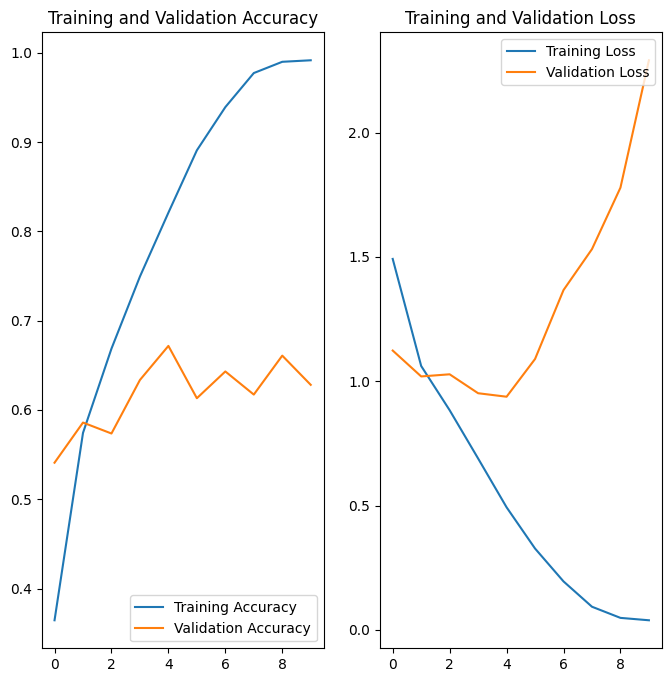

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

## Data augmentation

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

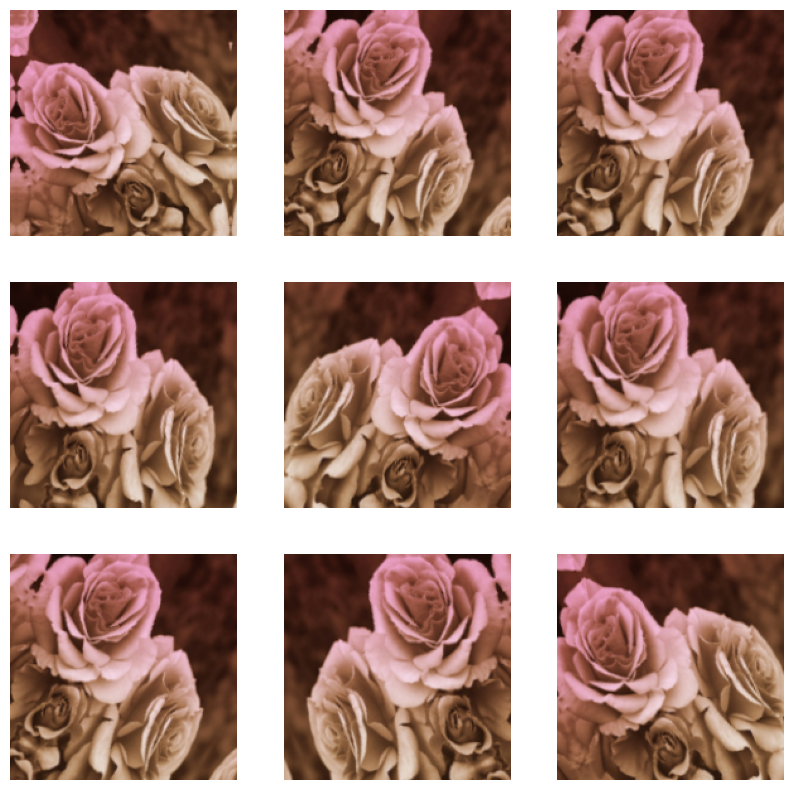

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout



In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential_1 (Sequential)   (None, 180, 180, 3)       0         


 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       


 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         


 g2D)                                                            


 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)        0         


 g2D)                                                            


 dropout (Dropout)           (None, 22, 22, 64)        0         


 flatten_1 (Flatten)         (None, 30976)             0         


 dense_2 (Dense)             (None, 128)               3965056   


 outputs (Dense)             (None, 5)                 645       


Total params: 3989285 (15.22 MB)


Trainable params: 3989285 (15.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2023-07-27 06:06:59.864648: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



 1/92 [..............................] - ETA: 2:49 - loss: 1.6287 - accuracy: 0.0625


 4/92 [>.............................] - ETA: 1s - loss: 1.9320 - accuracy: 0.1953  


 7/92 [=>............................] - ETA: 1s - loss: 1.7753 - accuracy: 0.2054


10/92 [==>...........................] - ETA: 1s - loss: 1.7068 - accuracy: 0.2375


13/92 [===>..........................] - ETA: 1s - loss: 1.6390 - accuracy: 0.2837


16/92 [====>.........................] - ETA: 1s - loss: 1.5958 - accuracy: 0.2910


19/92 [=====>........................] - ETA: 1s - loss: 1.5452 - accuracy: 0.3125


22/92 [======>.......................] - ETA: 1s - loss: 1.5125 - accuracy: 0.3247


25/92 [=======>......................] - ETA: 1s - loss: 1.4826 - accuracy: 0.3333


28/92 [========>.....................] - ETA: 1s - loss: 1.4627 - accuracy: 0.3435


31/92 [=========>....................] - ETA: 1s - loss: 1.4310 - accuracy: 0.3628


34/92 [==========>...................] - ETA: 1s - loss: 1.4175 - accuracy: 0.3667


37/92 [===========>..................] - ETA: 1s - loss: 1.3984 - accuracy: 0.3750


40/92 [============>.................] - ETA: 0s - loss: 1.3776 - accuracy: 0.3876


43/92 [=============>................] - ETA: 0s - loss: 1.3598 - accuracy: 0.3925


46/92 [==============>...............] - ETA: 0s - loss: 1.3614 - accuracy: 0.3982


49/92 [==============>...............] - ETA: 0s - loss: 1.3531 - accuracy: 0.4071


52/92 [===============>..............] - ETA: 0s - loss: 1.3421 - accuracy: 0.4118


55/92 [================>.............] - ETA: 0s - loss: 1.3297 - accuracy: 0.4201


58/92 [=================>............] - ETA: 0s - loss: 1.3188 - accuracy: 0.4280


61/92 [==================>...........] - ETA: 0s - loss: 1.3183 - accuracy: 0.4295


64/92 [===================>..........] - ETA: 0s - loss: 1.3026 - accuracy: 0.4382


67/92 [====================>.........] - ETA: 0s - loss: 1.2980 - accuracy: 0.4429


70/92 [=====================>........] - ETA: 0s - loss: 1.2947 - accuracy: 0.4449


73/92 [======================>.......] - ETA: 0s - loss: 1.2902 - accuracy: 0.4437


76/92 [=======================>......] - ETA: 0s - loss: 1.2859 - accuracy: 0.4451


79/92 [========================>.....] - ETA: 0s - loss: 1.2859 - accuracy: 0.4456


82/92 [=========================>....] - ETA: 0s - loss: 1.2810 - accuracy: 0.4480


85/92 [==========================>...] - ETA: 0s - loss: 1.2766 - accuracy: 0.4535


88/92 [===========================>..] - ETA: 0s - loss: 1.2718 - accuracy: 0.4569


91/92 [============================>.] - ETA: 0s - loss: 1.2650 - accuracy: 0.4604


92/92 [==============================] - 4s 22ms/step - loss: 1.2639 - accuracy: 0.4625 - val_loss: 1.1142 - val_accuracy: 0.5463


Epoch 2/15



 1/92 [..............................] - ETA: 1s - loss: 0.9923 - accuracy: 0.4688


 4/92 [>.............................] - ETA: 1s - loss: 1.0079 - accuracy: 0.6172


 7/92 [=>............................] - ETA: 1s - loss: 1.0698 - accuracy: 0.5491


10/92 [==>...........................] - ETA: 1s - loss: 1.0339 - accuracy: 0.5719


13/92 [===>..........................] - ETA: 1s - loss: 1.0627 - accuracy: 0.5673


16/92 [====>.........................] - ETA: 1s - loss: 1.0669 - accuracy: 0.5781


19/92 [=====>........................] - ETA: 1s - loss: 1.0454 - accuracy: 0.5839


22/92 [======>.......................] - ETA: 1s - loss: 1.0319 - accuracy: 0.5909


25/92 [=======>......................] - ETA: 1s - loss: 1.0263 - accuracy: 0.5987


28/92 [========>.....................] - ETA: 1s - loss: 1.0434 - accuracy: 0.5926


31/92 [=========>....................] - ETA: 1s - loss: 1.0387 - accuracy: 0.5948


34/92 [==========>...................] - ETA: 1s - loss: 1.0377 - accuracy: 0.5965


37/92 [===========>..................] - ETA: 1s - loss: 1.0450 - accuracy: 0.5895


40/92 [============>.................] - ETA: 0s - loss: 1.0361 - accuracy: 0.5961


43/92 [=============>................] - ETA: 0s - loss: 1.0293 - accuracy: 0.5967


46/92 [==============>...............] - ETA: 0s - loss: 1.0259 - accuracy: 0.5985


49/92 [==============>...............] - ETA: 0s - loss: 1.0225 - accuracy: 0.6001


52/92 [===============>..............] - ETA: 0s - loss: 1.0200 - accuracy: 0.5992


55/92 [================>.............] - ETA: 0s - loss: 1.0197 - accuracy: 0.6016


58/92 [=================>............] - ETA: 0s - loss: 1.0114 - accuracy: 0.6061


61/92 [==================>...........] - ETA: 0s - loss: 1.0151 - accuracy: 0.6055


64/92 [===================>..........] - ETA: 0s - loss: 1.0096 - accuracy: 0.6059


67/92 [====================>.........] - ETA: 0s - loss: 1.0054 - accuracy: 0.6091


70/92 [=====================>........] - ETA: 0s - loss: 1.0033 - accuracy: 0.6035


73/92 [======================>.......] - ETA: 0s - loss: 1.0032 - accuracy: 0.6057


76/92 [=======================>......] - ETA: 0s - loss: 1.0077 - accuracy: 0.6023


79/92 [========================>.....] - ETA: 0s - loss: 1.0034 - accuracy: 0.6036


82/92 [=========================>....] - ETA: 0s - loss: 1.0020 - accuracy: 0.6044


85/92 [==========================>...] - ETA: 0s - loss: 0.9991 - accuracy: 0.6058


88/92 [===========================>..] - ETA: 0s - loss: 0.9974 - accuracy: 0.6061


91/92 [============================>.] - ETA: 0s - loss: 0.9989 - accuracy: 0.6050


92/92 [==============================] - 2s 21ms/step - loss: 0.9987 - accuracy: 0.6059 - val_loss: 1.0628 - val_accuracy: 0.5817


Epoch 3/15



 1/92 [..............................] - ETA: 1s - loss: 0.8554 - accuracy: 0.6250


 4/92 [>.............................] - ETA: 1s - loss: 0.9088 - accuracy: 0.6484


 7/92 [=>............................] - ETA: 1s - loss: 0.8717 - accuracy: 0.6429


10/92 [==>...........................] - ETA: 1s - loss: 0.9493 - accuracy: 0.6219


13/92 [===>..........................] - ETA: 1s - loss: 0.9404 - accuracy: 0.6154


16/92 [====>.........................] - ETA: 1s - loss: 0.9241 - accuracy: 0.6230


19/92 [=====>........................] - ETA: 1s - loss: 0.9277 - accuracy: 0.6234


22/92 [======>.......................] - ETA: 1s - loss: 0.9452 - accuracy: 0.6193


25/92 [=======>......................] - ETA: 1s - loss: 0.9578 - accuracy: 0.6162


28/92 [========>.....................] - ETA: 1s - loss: 0.9513 - accuracy: 0.6250


31/92 [=========>....................] - ETA: 1s - loss: 0.9388 - accuracy: 0.6270


34/92 [==========>...................] - ETA: 1s - loss: 0.9503 - accuracy: 0.6241


37/92 [===========>..................] - ETA: 1s - loss: 0.9430 - accuracy: 0.6301


40/92 [============>.................] - ETA: 0s - loss: 0.9391 - accuracy: 0.6336


43/92 [=============>................] - ETA: 0s - loss: 0.9402 - accuracy: 0.6294


46/92 [==============>...............] - ETA: 0s - loss: 0.9334 - accuracy: 0.6339


49/92 [==============>...............] - ETA: 0s - loss: 0.9299 - accuracy: 0.6353


52/92 [===============>..............] - ETA: 0s - loss: 0.9251 - accuracy: 0.6389


55/92 [================>.............] - ETA: 0s - loss: 0.9212 - accuracy: 0.6404


58/92 [=================>............] - ETA: 0s - loss: 0.9180 - accuracy: 0.6429


61/92 [==================>...........] - ETA: 0s - loss: 0.9176 - accuracy: 0.6425


64/92 [===================>..........] - ETA: 0s - loss: 0.9212 - accuracy: 0.6417


67/92 [====================>.........] - ETA: 0s - loss: 0.9183 - accuracy: 0.6423


70/92 [=====================>........] - ETA: 0s - loss: 0.9184 - accuracy: 0.6420


73/92 [======================>.......] - ETA: 0s - loss: 0.9151 - accuracy: 0.6418


76/92 [=======================>......] - ETA: 0s - loss: 0.9120 - accuracy: 0.6440


79/92 [========================>.....] - ETA: 0s - loss: 0.9094 - accuracy: 0.6437


82/92 [=========================>....] - ETA: 0s - loss: 0.9142 - accuracy: 0.6418


85/92 [==========================>...] - ETA: 0s - loss: 0.9096 - accuracy: 0.6442


88/92 [===========================>..] - ETA: 0s - loss: 0.9154 - accuracy: 0.6421


91/92 [============================>.] - ETA: 0s - loss: 0.9190 - accuracy: 0.6402


92/92 [==============================] - 2s 21ms/step - loss: 0.9178 - accuracy: 0.6407 - val_loss: 0.8788 - val_accuracy: 0.6376


Epoch 4/15



 1/92 [..............................] - ETA: 1s - loss: 0.7969 - accuracy: 0.7188


 4/92 [>.............................] - ETA: 1s - loss: 0.8972 - accuracy: 0.6172


 7/92 [=>............................] - ETA: 1s - loss: 0.8474 - accuracy: 0.6384


10/92 [==>...........................] - ETA: 1s - loss: 0.8563 - accuracy: 0.6406


13/92 [===>..........................] - ETA: 1s - loss: 0.8453 - accuracy: 0.6418


16/92 [====>.........................] - ETA: 1s - loss: 0.8738 - accuracy: 0.6465


19/92 [=====>........................] - ETA: 1s - loss: 0.8774 - accuracy: 0.6316


22/92 [======>.......................] - ETA: 1s - loss: 0.9036 - accuracy: 0.6236


25/92 [=======>......................] - ETA: 1s - loss: 0.8967 - accuracy: 0.6225


28/92 [========>.....................] - ETA: 1s - loss: 0.8887 - accuracy: 0.6295


31/92 [=========>....................] - ETA: 1s - loss: 0.8962 - accuracy: 0.6300


34/92 [==========>...................] - ETA: 1s - loss: 0.8971 - accuracy: 0.6305


37/92 [===========>..................] - ETA: 1s - loss: 0.8896 - accuracy: 0.6343


40/92 [============>.................] - ETA: 0s - loss: 0.8806 - accuracy: 0.6398


43/92 [=============>................] - ETA: 0s - loss: 0.8755 - accuracy: 0.6446


46/92 [==============>...............] - ETA: 0s - loss: 0.8707 - accuracy: 0.6454


49/92 [==============>...............] - ETA: 0s - loss: 0.8674 - accuracy: 0.6480


52/92 [===============>..............] - ETA: 0s - loss: 0.8614 - accuracy: 0.6496


55/92 [================>.............] - ETA: 0s - loss: 0.8652 - accuracy: 0.6506


58/92 [=================>............] - ETA: 0s - loss: 0.8636 - accuracy: 0.6536


61/92 [==================>...........] - ETA: 0s - loss: 0.8664 - accuracy: 0.6542


64/92 [===================>..........] - ETA: 0s - loss: 0.8646 - accuracy: 0.6528


67/92 [====================>.........] - ETA: 0s - loss: 0.8629 - accuracy: 0.6525


70/92 [=====================>........] - ETA: 0s - loss: 0.8619 - accuracy: 0.6545


73/92 [======================>.......] - ETA: 0s - loss: 0.8693 - accuracy: 0.6528


76/92 [=======================>......] - ETA: 0s - loss: 0.8649 - accuracy: 0.6542


79/92 [========================>.....] - ETA: 0s - loss: 0.8656 - accuracy: 0.6560


82/92 [=========================>....] - ETA: 0s - loss: 0.8715 - accuracy: 0.6514


85/92 [==========================>...] - ETA: 0s - loss: 0.8757 - accuracy: 0.6508


88/92 [===========================>..] - ETA: 0s - loss: 0.8704 - accuracy: 0.6542


91/92 [============================>.] - ETA: 0s - loss: 0.8715 - accuracy: 0.6539


92/92 [==============================] - 2s 21ms/step - loss: 0.8688 - accuracy: 0.6557 - val_loss: 0.8225 - val_accuracy: 0.6730


Epoch 5/15



 1/92 [..............................] - ETA: 1s - loss: 0.6377 - accuracy: 0.7500


 4/92 [>.............................] - ETA: 1s - loss: 0.7799 - accuracy: 0.6953


 7/92 [=>............................] - ETA: 1s - loss: 0.8201 - accuracy: 0.6786


10/92 [==>...........................] - ETA: 1s - loss: 0.8261 - accuracy: 0.6812


13/92 [===>..........................] - ETA: 1s - loss: 0.8179 - accuracy: 0.6827


16/92 [====>.........................] - ETA: 1s - loss: 0.8015 - accuracy: 0.6895


19/92 [=====>........................] - ETA: 1s - loss: 0.7958 - accuracy: 0.6859


22/92 [======>.......................] - ETA: 1s - loss: 0.8037 - accuracy: 0.6804


25/92 [=======>......................] - ETA: 1s - loss: 0.7959 - accuracy: 0.6825


28/92 [========>.....................] - ETA: 1s - loss: 0.7842 - accuracy: 0.6897


31/92 [=========>....................] - ETA: 1s - loss: 0.7735 - accuracy: 0.6946


34/92 [==========>...................] - ETA: 1s - loss: 0.7974 - accuracy: 0.6903


37/92 [===========>..................] - ETA: 1s - loss: 0.8059 - accuracy: 0.6867


40/92 [============>.................] - ETA: 0s - loss: 0.8026 - accuracy: 0.6903


43/92 [=============>................] - ETA: 0s - loss: 0.8051 - accuracy: 0.6893


46/92 [==============>...............] - ETA: 0s - loss: 0.8034 - accuracy: 0.6899


49/92 [==============>...............] - ETA: 0s - loss: 0.7944 - accuracy: 0.6897


52/92 [===============>..............] - ETA: 0s - loss: 0.7954 - accuracy: 0.6890


55/92 [================>.............] - ETA: 0s - loss: 0.7914 - accuracy: 0.6901


58/92 [=================>............] - ETA: 0s - loss: 0.7969 - accuracy: 0.6861


61/92 [==================>...........] - ETA: 0s - loss: 0.8030 - accuracy: 0.6847


64/92 [===================>..........] - ETA: 0s - loss: 0.8005 - accuracy: 0.6863


67/92 [====================>.........] - ETA: 0s - loss: 0.8043 - accuracy: 0.6831


70/92 [=====================>........] - ETA: 0s - loss: 0.8039 - accuracy: 0.6841


73/92 [======================>.......] - ETA: 0s - loss: 0.8038 - accuracy: 0.6847


76/92 [=======================>......] - ETA: 0s - loss: 0.8070 - accuracy: 0.6832


79/92 [========================>.....] - ETA: 0s - loss: 0.8001 - accuracy: 0.6889


82/92 [=========================>....] - ETA: 0s - loss: 0.8006 - accuracy: 0.6888


85/92 [==========================>...] - ETA: 0s - loss: 0.8045 - accuracy: 0.6884


88/92 [===========================>..] - ETA: 0s - loss: 0.8015 - accuracy: 0.6895


91/92 [============================>.] - ETA: 0s - loss: 0.7999 - accuracy: 0.6904


92/92 [==============================] - 2s 21ms/step - loss: 0.8004 - accuracy: 0.6907 - val_loss: 0.7736 - val_accuracy: 0.6935


Epoch 6/15



 1/92 [..............................] - ETA: 1s - loss: 1.1494 - accuracy: 0.5000


 4/92 [>.............................] - ETA: 1s - loss: 0.8626 - accuracy: 0.6641


 7/92 [=>............................] - ETA: 1s - loss: 0.8222 - accuracy: 0.6607


10/92 [==>...........................] - ETA: 1s - loss: 0.7859 - accuracy: 0.6844


13/92 [===>..........................] - ETA: 1s - loss: 0.7832 - accuracy: 0.6851


16/92 [====>.........................] - ETA: 1s - loss: 0.7441 - accuracy: 0.7012


19/92 [=====>........................] - ETA: 1s - loss: 0.7427 - accuracy: 0.7056


22/92 [======>.......................] - ETA: 1s - loss: 0.7425 - accuracy: 0.7088


25/92 [=======>......................] - ETA: 1s - loss: 0.7364 - accuracy: 0.7138


28/92 [========>.....................] - ETA: 1s - loss: 0.7378 - accuracy: 0.7165


31/92 [=========>....................] - ETA: 1s - loss: 0.7345 - accuracy: 0.7157


34/92 [==========>...................] - ETA: 1s - loss: 0.7455 - accuracy: 0.7096


37/92 [===========>..................] - ETA: 1s - loss: 0.7342 - accuracy: 0.7154


40/92 [============>.................] - ETA: 0s - loss: 0.7358 - accuracy: 0.7172


43/92 [=============>................] - ETA: 0s - loss: 0.7405 - accuracy: 0.7158


46/92 [==============>...............] - ETA: 0s - loss: 0.7451 - accuracy: 0.7160


49/92 [==============>...............] - ETA: 0s - loss: 0.7513 - accuracy: 0.7149


52/92 [===============>..............] - ETA: 0s - loss: 0.7550 - accuracy: 0.7139


55/92 [================>.............] - ETA: 0s - loss: 0.7570 - accuracy: 0.7131


58/92 [=================>............] - ETA: 0s - loss: 0.7563 - accuracy: 0.7112


61/92 [==================>...........] - ETA: 0s - loss: 0.7582 - accuracy: 0.7095


64/92 [===================>..........] - ETA: 0s - loss: 0.7609 - accuracy: 0.7090


67/92 [====================>.........] - ETA: 0s - loss: 0.7582 - accuracy: 0.7104


70/92 [=====================>........] - ETA: 0s - loss: 0.7540 - accuracy: 0.7112


73/92 [======================>.......] - ETA: 0s - loss: 0.7599 - accuracy: 0.7089


76/92 [=======================>......] - ETA: 0s - loss: 0.7626 - accuracy: 0.7068


79/92 [========================>.....] - ETA: 0s - loss: 0.7640 - accuracy: 0.7040


82/92 [=========================>....] - ETA: 0s - loss: 0.7638 - accuracy: 0.7041


85/92 [==========================>...] - ETA: 0s - loss: 0.7680 - accuracy: 0.7028


88/92 [===========================>..] - ETA: 0s - loss: 0.7661 - accuracy: 0.7033


91/92 [============================>.] - ETA: 0s - loss: 0.7643 - accuracy: 0.7042


92/92 [==============================] - 2s 21ms/step - loss: 0.7654 - accuracy: 0.7033 - val_loss: 0.8150 - val_accuracy: 0.6880


Epoch 7/15



 1/92 [..............................] - ETA: 1s - loss: 0.5906 - accuracy: 0.6562


 4/92 [>.............................] - ETA: 1s - loss: 0.6640 - accuracy: 0.7500


 7/92 [=>............................] - ETA: 1s - loss: 0.7108 - accuracy: 0.7366


10/92 [==>...........................] - ETA: 1s - loss: 0.7087 - accuracy: 0.7281


13/92 [===>..........................] - ETA: 1s - loss: 0.7188 - accuracy: 0.7404


16/92 [====>.........................] - ETA: 1s - loss: 0.7241 - accuracy: 0.7305


19/92 [=====>........................] - ETA: 1s - loss: 0.7276 - accuracy: 0.7204


22/92 [======>.......................] - ETA: 1s - loss: 0.7533 - accuracy: 0.7116


25/92 [=======>......................] - ETA: 1s - loss: 0.7397 - accuracy: 0.7212


28/92 [========>.....................] - ETA: 1s - loss: 0.7211 - accuracy: 0.7310


31/92 [=========>....................] - ETA: 1s - loss: 0.7155 - accuracy: 0.7349


34/92 [==========>...................] - ETA: 1s - loss: 0.7188 - accuracy: 0.7289


37/92 [===========>..................] - ETA: 1s - loss: 0.7202 - accuracy: 0.7204


40/92 [============>.................] - ETA: 0s - loss: 0.7149 - accuracy: 0.7219


43/92 [=============>................] - ETA: 0s - loss: 0.7230 - accuracy: 0.7180


46/92 [==============>...............] - ETA: 0s - loss: 0.7279 - accuracy: 0.7160


49/92 [==============>...............] - ETA: 0s - loss: 0.7274 - accuracy: 0.7175


52/92 [===============>..............] - ETA: 0s - loss: 0.7244 - accuracy: 0.7200


55/92 [================>.............] - ETA: 0s - loss: 0.7244 - accuracy: 0.7176


58/92 [=================>............] - ETA: 0s - loss: 0.7240 - accuracy: 0.7188


61/92 [==================>...........] - ETA: 0s - loss: 0.7392 - accuracy: 0.7131


64/92 [===================>..........] - ETA: 0s - loss: 0.7443 - accuracy: 0.7119


67/92 [====================>.........] - ETA: 0s - loss: 0.7562 - accuracy: 0.7071


70/92 [=====================>........] - ETA: 0s - loss: 0.7605 - accuracy: 0.7054


73/92 [======================>.......] - ETA: 0s - loss: 0.7609 - accuracy: 0.7068


76/92 [=======================>......] - ETA: 0s - loss: 0.7592 - accuracy: 0.7105


79/92 [========================>.....] - ETA: 0s - loss: 0.7651 - accuracy: 0.7081


82/92 [=========================>....] - ETA: 0s - loss: 0.7616 - accuracy: 0.7073


85/92 [==========================>...] - ETA: 0s - loss: 0.7613 - accuracy: 0.7059


88/92 [===========================>..] - ETA: 0s - loss: 0.7599 - accuracy: 0.7067


91/92 [============================>.] - ETA: 0s - loss: 0.7560 - accuracy: 0.7083


92/92 [==============================] - 2s 21ms/step - loss: 0.7564 - accuracy: 0.7091 - val_loss: 0.8144 - val_accuracy: 0.6826


Epoch 8/15



 1/92 [..............................] - ETA: 1s - loss: 0.6791 - accuracy: 0.7500


 4/92 [>.............................] - ETA: 1s - loss: 0.6590 - accuracy: 0.7422


 7/92 [=>............................] - ETA: 1s - loss: 0.7074 - accuracy: 0.7321


10/92 [==>...........................] - ETA: 1s - loss: 0.6902 - accuracy: 0.7375


13/92 [===>..........................] - ETA: 1s - loss: 0.6747 - accuracy: 0.7380


16/92 [====>.........................] - ETA: 1s - loss: 0.6945 - accuracy: 0.7246


19/92 [=====>........................] - ETA: 1s - loss: 0.7129 - accuracy: 0.7155


22/92 [======>.......................] - ETA: 1s - loss: 0.6952 - accuracy: 0.7213


25/92 [=======>......................] - ETA: 1s - loss: 0.6975 - accuracy: 0.7247


28/92 [========>.....................] - ETA: 1s - loss: 0.7051 - accuracy: 0.7218


31/92 [=========>....................] - ETA: 1s - loss: 0.7100 - accuracy: 0.7205


34/92 [==========>...................] - ETA: 1s - loss: 0.7102 - accuracy: 0.7213


37/92 [===========>..................] - ETA: 1s - loss: 0.7058 - accuracy: 0.7228


40/92 [============>.................] - ETA: 0s - loss: 0.7094 - accuracy: 0.7225


43/92 [=============>................] - ETA: 0s - loss: 0.7057 - accuracy: 0.7237


46/92 [==============>...............] - ETA: 0s - loss: 0.6998 - accuracy: 0.7288


49/92 [==============>...............] - ETA: 0s - loss: 0.7022 - accuracy: 0.7282


52/92 [===============>..............] - ETA: 0s - loss: 0.6940 - accuracy: 0.7313


55/92 [================>.............] - ETA: 0s - loss: 0.6975 - accuracy: 0.7306


58/92 [=================>............] - ETA: 0s - loss: 0.6967 - accuracy: 0.7311


61/92 [==================>...........] - ETA: 0s - loss: 0.6995 - accuracy: 0.7310


64/92 [===================>..........] - ETA: 0s - loss: 0.6947 - accuracy: 0.7319


67/92 [====================>.........] - ETA: 0s - loss: 0.6904 - accuracy: 0.7350


70/92 [=====================>........] - ETA: 0s - loss: 0.6877 - accuracy: 0.7370


73/92 [======================>.......] - ETA: 0s - loss: 0.6892 - accuracy: 0.7358


76/92 [=======================>......] - ETA: 0s - loss: 0.6920 - accuracy: 0.7364


79/92 [========================>.....] - ETA: 0s - loss: 0.6863 - accuracy: 0.7389


82/92 [=========================>....] - ETA: 0s - loss: 0.6858 - accuracy: 0.7408


85/92 [==========================>...] - ETA: 0s - loss: 0.6890 - accuracy: 0.7400


88/92 [===========================>..] - ETA: 0s - loss: 0.6889 - accuracy: 0.7397


91/92 [============================>.] - ETA: 0s - loss: 0.6897 - accuracy: 0.7390


92/92 [==============================] - 2s 21ms/step - loss: 0.6899 - accuracy: 0.7388 - val_loss: 0.7152 - val_accuracy: 0.7193


Epoch 9/15



 1/92 [..............................] - ETA: 1s - loss: 0.8216 - accuracy: 0.5938


 4/92 [>.............................] - ETA: 1s - loss: 0.6245 - accuracy: 0.7031


 7/92 [=>............................] - ETA: 1s - loss: 0.6246 - accuracy: 0.7366


10/92 [==>...........................] - ETA: 1s - loss: 0.6265 - accuracy: 0.7406


13/92 [===>..........................] - ETA: 1s - loss: 0.6474 - accuracy: 0.7452


16/92 [====>.........................] - ETA: 1s - loss: 0.6453 - accuracy: 0.7520


19/92 [=====>........................] - ETA: 1s - loss: 0.6560 - accuracy: 0.7451


22/92 [======>.......................] - ETA: 1s - loss: 0.6594 - accuracy: 0.7472


25/92 [=======>......................] - ETA: 1s - loss: 0.6434 - accuracy: 0.7625


28/92 [========>.....................] - ETA: 1s - loss: 0.6500 - accuracy: 0.7600


31/92 [=========>....................] - ETA: 1s - loss: 0.6548 - accuracy: 0.7560


34/92 [==========>...................] - ETA: 1s - loss: 0.6562 - accuracy: 0.7555


37/92 [===========>..................] - ETA: 1s - loss: 0.6606 - accuracy: 0.7551


40/92 [============>.................] - ETA: 0s - loss: 0.6584 - accuracy: 0.7539


43/92 [=============>................] - ETA: 0s - loss: 0.6623 - accuracy: 0.7515


46/92 [==============>...............] - ETA: 0s - loss: 0.6565 - accuracy: 0.7554


49/92 [==============>...............] - ETA: 0s - loss: 0.6620 - accuracy: 0.7506


52/92 [===============>..............] - ETA: 0s - loss: 0.6631 - accuracy: 0.7476


55/92 [================>.............] - ETA: 0s - loss: 0.6579 - accuracy: 0.7483


58/92 [=================>............] - ETA: 0s - loss: 0.6507 - accuracy: 0.7522


61/92 [==================>...........] - ETA: 0s - loss: 0.6485 - accuracy: 0.7531


64/92 [===================>..........] - ETA: 0s - loss: 0.6492 - accuracy: 0.7524


67/92 [====================>.........] - ETA: 0s - loss: 0.6526 - accuracy: 0.7509


70/92 [=====================>........] - ETA: 0s - loss: 0.6572 - accuracy: 0.7491


73/92 [======================>.......] - ETA: 0s - loss: 0.6575 - accuracy: 0.7496


76/92 [=======================>......] - ETA: 0s - loss: 0.6573 - accuracy: 0.7459


79/92 [========================>.....] - ETA: 0s - loss: 0.6615 - accuracy: 0.7453


82/92 [=========================>....] - ETA: 0s - loss: 0.6694 - accuracy: 0.7401


85/92 [==========================>...] - ETA: 0s - loss: 0.6684 - accuracy: 0.7423


88/92 [===========================>..] - ETA: 0s - loss: 0.6691 - accuracy: 0.7432


91/92 [============================>.] - ETA: 0s - loss: 0.6643 - accuracy: 0.7462


92/92 [==============================] - 2s 21ms/step - loss: 0.6624 - accuracy: 0.7463 - val_loss: 0.7008 - val_accuracy: 0.7234


Epoch 10/15



 1/92 [..............................] - ETA: 1s - loss: 0.8007 - accuracy: 0.5625


 4/92 [>.............................] - ETA: 1s - loss: 0.6595 - accuracy: 0.6641


 7/92 [=>............................] - ETA: 1s - loss: 0.6311 - accuracy: 0.7098


10/92 [==>...........................] - ETA: 1s - loss: 0.6250 - accuracy: 0.7250


13/92 [===>..........................] - ETA: 1s - loss: 0.6375 - accuracy: 0.7284


16/92 [====>.........................] - ETA: 1s - loss: 0.6277 - accuracy: 0.7422


19/92 [=====>........................] - ETA: 1s - loss: 0.6232 - accuracy: 0.7434


22/92 [======>.......................] - ETA: 1s - loss: 0.6198 - accuracy: 0.7443


25/92 [=======>......................] - ETA: 1s - loss: 0.6307 - accuracy: 0.7462


28/92 [========>.....................] - ETA: 1s - loss: 0.6340 - accuracy: 0.7489


31/92 [=========>....................] - ETA: 1s - loss: 0.6283 - accuracy: 0.7530


34/92 [==========>...................] - ETA: 1s - loss: 0.6195 - accuracy: 0.7583


37/92 [===========>..................] - ETA: 1s - loss: 0.6063 - accuracy: 0.7686


40/92 [============>.................] - ETA: 0s - loss: 0.6107 - accuracy: 0.7672


43/92 [=============>................] - ETA: 0s - loss: 0.6079 - accuracy: 0.7653


46/92 [==============>...............] - ETA: 0s - loss: 0.6161 - accuracy: 0.7636


49/92 [==============>...............] - ETA: 0s - loss: 0.6125 - accuracy: 0.7621


52/92 [===============>..............] - ETA: 0s - loss: 0.6051 - accuracy: 0.7686


55/92 [================>.............] - ETA: 0s - loss: 0.6051 - accuracy: 0.7688


58/92 [=================>............] - ETA: 0s - loss: 0.5988 - accuracy: 0.7716


61/92 [==================>...........] - ETA: 0s - loss: 0.5975 - accuracy: 0.7710


64/92 [===================>..........] - ETA: 0s - loss: 0.5956 - accuracy: 0.7710


67/92 [====================>.........] - ETA: 0s - loss: 0.6041 - accuracy: 0.7673


70/92 [=====================>........] - ETA: 0s - loss: 0.6066 - accuracy: 0.7661


73/92 [======================>.......] - ETA: 0s - loss: 0.6070 - accuracy: 0.7663


76/92 [=======================>......] - ETA: 0s - loss: 0.6112 - accuracy: 0.7636


79/92 [========================>.....] - ETA: 0s - loss: 0.6065 - accuracy: 0.7667


82/92 [=========================>....] - ETA: 0s - loss: 0.6112 - accuracy: 0.7641


85/92 [==========================>...] - ETA: 0s - loss: 0.6139 - accuracy: 0.7629


88/92 [===========================>..] - ETA: 0s - loss: 0.6191 - accuracy: 0.7600


91/92 [============================>.] - ETA: 0s - loss: 0.6207 - accuracy: 0.7610


92/92 [==============================] - 2s 21ms/step - loss: 0.6243 - accuracy: 0.7599 - val_loss: 0.7120 - val_accuracy: 0.7084


Epoch 11/15



 1/92 [..............................] - ETA: 1s - loss: 0.6578 - accuracy: 0.7500


 4/92 [>.............................] - ETA: 1s - loss: 0.5690 - accuracy: 0.7891


 7/92 [=>............................] - ETA: 1s - loss: 0.5861 - accuracy: 0.7857


10/92 [==>...........................] - ETA: 1s - loss: 0.6086 - accuracy: 0.7656


13/92 [===>..........................] - ETA: 1s - loss: 0.6081 - accuracy: 0.7647


16/92 [====>.........................] - ETA: 1s - loss: 0.6168 - accuracy: 0.7599


19/92 [=====>........................] - ETA: 1s - loss: 0.6404 - accuracy: 0.7550


22/92 [======>.......................] - ETA: 1s - loss: 0.6217 - accuracy: 0.7629


25/92 [=======>......................] - ETA: 1s - loss: 0.6119 - accuracy: 0.7652


28/92 [========>.....................] - ETA: 1s - loss: 0.6093 - accuracy: 0.7624


31/92 [=========>....................] - ETA: 1s - loss: 0.6153 - accuracy: 0.7602


34/92 [==========>...................] - ETA: 1s - loss: 0.6158 - accuracy: 0.7593


37/92 [===========>..................] - ETA: 1s - loss: 0.6144 - accuracy: 0.7619


40/92 [============>.................] - ETA: 0s - loss: 0.6120 - accuracy: 0.7673


43/92 [=============>................] - ETA: 0s - loss: 0.6154 - accuracy: 0.7639


46/92 [==============>...............] - ETA: 0s - loss: 0.6231 - accuracy: 0.7596


49/92 [==============>...............] - ETA: 0s - loss: 0.6204 - accuracy: 0.7628


52/92 [===============>..............] - ETA: 0s - loss: 0.6177 - accuracy: 0.7615


55/92 [================>.............] - ETA: 0s - loss: 0.6251 - accuracy: 0.7597


58/92 [=================>............] - ETA: 0s - loss: 0.6265 - accuracy: 0.7570


61/92 [==================>...........] - ETA: 0s - loss: 0.6298 - accuracy: 0.7567


64/92 [===================>..........] - ETA: 0s - loss: 0.6295 - accuracy: 0.7564


67/92 [====================>.........] - ETA: 0s - loss: 0.6343 - accuracy: 0.7547


70/92 [=====================>........] - ETA: 0s - loss: 0.6378 - accuracy: 0.7540


73/92 [======================>.......] - ETA: 0s - loss: 0.6351 - accuracy: 0.7564


76/92 [=======================>......] - ETA: 0s - loss: 0.6402 - accuracy: 0.7554


79/92 [========================>.....] - ETA: 0s - loss: 0.6393 - accuracy: 0.7560


82/92 [=========================>....] - ETA: 0s - loss: 0.6427 - accuracy: 0.7542


85/92 [==========================>...] - ETA: 0s - loss: 0.6400 - accuracy: 0.7548


88/92 [===========================>..] - ETA: 0s - loss: 0.6383 - accuracy: 0.7550


91/92 [============================>.] - ETA: 0s - loss: 0.6413 - accuracy: 0.7534


92/92 [==============================] - 2s 21ms/step - loss: 0.6410 - accuracy: 0.7534 - val_loss: 0.6971 - val_accuracy: 0.7207


Epoch 12/15



 1/92 [..............................] - ETA: 1s - loss: 0.6873 - accuracy: 0.7812


 4/92 [>.............................] - ETA: 1s - loss: 0.5572 - accuracy: 0.8281


 7/92 [=>............................] - ETA: 1s - loss: 0.5955 - accuracy: 0.7991


10/92 [==>...........................] - ETA: 1s - loss: 0.5698 - accuracy: 0.8094


13/92 [===>..........................] - ETA: 1s - loss: 0.5795 - accuracy: 0.7981


16/92 [====>.........................] - ETA: 1s - loss: 0.6006 - accuracy: 0.7832


19/92 [=====>........................] - ETA: 1s - loss: 0.6084 - accuracy: 0.7763


22/92 [======>.......................] - ETA: 1s - loss: 0.6007 - accuracy: 0.7770


25/92 [=======>......................] - ETA: 1s - loss: 0.5923 - accuracy: 0.7800


28/92 [========>.....................] - ETA: 1s - loss: 0.5793 - accuracy: 0.7824


31/92 [=========>....................] - ETA: 1s - loss: 0.5932 - accuracy: 0.7752


34/92 [==========>...................] - ETA: 1s - loss: 0.5955 - accuracy: 0.7702


37/92 [===========>..................] - ETA: 1s - loss: 0.5914 - accuracy: 0.7711


40/92 [============>.................] - ETA: 0s - loss: 0.5975 - accuracy: 0.7695


43/92 [=============>................] - ETA: 0s - loss: 0.6026 - accuracy: 0.7682


46/92 [==============>...............] - ETA: 0s - loss: 0.5993 - accuracy: 0.7683


49/92 [==============>...............] - ETA: 0s - loss: 0.5964 - accuracy: 0.7710


52/92 [===============>..............] - ETA: 0s - loss: 0.5975 - accuracy: 0.7692


55/92 [================>.............] - ETA: 0s - loss: 0.5950 - accuracy: 0.7688


58/92 [=================>............] - ETA: 0s - loss: 0.5983 - accuracy: 0.7683


61/92 [==================>...........] - ETA: 0s - loss: 0.5954 - accuracy: 0.7674


64/92 [===================>..........] - ETA: 0s - loss: 0.5937 - accuracy: 0.7666


67/92 [====================>.........] - ETA: 0s - loss: 0.5914 - accuracy: 0.7687


70/92 [=====================>........] - ETA: 0s - loss: 0.5856 - accuracy: 0.7711


73/92 [======================>.......] - ETA: 0s - loss: 0.5890 - accuracy: 0.7706


76/92 [=======================>......] - ETA: 0s - loss: 0.5828 - accuracy: 0.7739


79/92 [========================>.....] - ETA: 0s - loss: 0.5842 - accuracy: 0.7726


82/92 [=========================>....] - ETA: 0s - loss: 0.5812 - accuracy: 0.7729


85/92 [==========================>...] - ETA: 0s - loss: 0.5844 - accuracy: 0.7721


88/92 [===========================>..] - ETA: 0s - loss: 0.5853 - accuracy: 0.7699


91/92 [============================>.] - ETA: 0s - loss: 0.5816 - accuracy: 0.7717


92/92 [==============================] - 2s 21ms/step - loss: 0.5785 - accuracy: 0.7732 - val_loss: 0.6794 - val_accuracy: 0.7384


Epoch 13/15



 1/92 [..............................] - ETA: 1s - loss: 0.5177 - accuracy: 0.7188


 4/92 [>.............................] - ETA: 1s - loss: 0.4358 - accuracy: 0.8203


 7/92 [=>............................] - ETA: 1s - loss: 0.4805 - accuracy: 0.8170


10/92 [==>...........................] - ETA: 1s - loss: 0.5158 - accuracy: 0.8031


13/92 [===>..........................] - ETA: 1s - loss: 0.5086 - accuracy: 0.8053


16/92 [====>.........................] - ETA: 1s - loss: 0.5234 - accuracy: 0.8047


19/92 [=====>........................] - ETA: 1s - loss: 0.5195 - accuracy: 0.8026


22/92 [======>.......................] - ETA: 1s - loss: 0.5190 - accuracy: 0.7997


25/92 [=======>......................] - ETA: 1s - loss: 0.5061 - accuracy: 0.8087


28/92 [========>.....................] - ETA: 1s - loss: 0.5210 - accuracy: 0.8058


31/92 [=========>....................] - ETA: 1s - loss: 0.5242 - accuracy: 0.8034


34/92 [==========>...................] - ETA: 1s - loss: 0.5360 - accuracy: 0.8033


37/92 [===========>..................] - ETA: 1s - loss: 0.5341 - accuracy: 0.8015


40/92 [============>.................] - ETA: 0s - loss: 0.5277 - accuracy: 0.8008


43/92 [=============>................] - ETA: 0s - loss: 0.5291 - accuracy: 0.8009


46/92 [==============>...............] - ETA: 0s - loss: 0.5220 - accuracy: 0.8057


49/92 [==============>...............] - ETA: 0s - loss: 0.5352 - accuracy: 0.8029


52/92 [===============>..............] - ETA: 0s - loss: 0.5410 - accuracy: 0.8017


55/92 [================>.............] - ETA: 0s - loss: 0.5438 - accuracy: 0.7997


58/92 [=================>............] - ETA: 0s - loss: 0.5505 - accuracy: 0.7960


61/92 [==================>...........] - ETA: 0s - loss: 0.5517 - accuracy: 0.7973


64/92 [===================>..........] - ETA: 0s - loss: 0.5497 - accuracy: 0.7975


67/92 [====================>.........] - ETA: 0s - loss: 0.5531 - accuracy: 0.7963


70/92 [=====================>........] - ETA: 0s - loss: 0.5547 - accuracy: 0.7957


73/92 [======================>.......] - ETA: 0s - loss: 0.5501 - accuracy: 0.7973


76/92 [=======================>......] - ETA: 0s - loss: 0.5503 - accuracy: 0.7970


79/92 [========================>.....] - ETA: 0s - loss: 0.5479 - accuracy: 0.7980


82/92 [=========================>....] - ETA: 0s - loss: 0.5473 - accuracy: 0.7970


85/92 [==========================>...] - ETA: 0s - loss: 0.5449 - accuracy: 0.7972


88/92 [===========================>..] - ETA: 0s - loss: 0.5454 - accuracy: 0.7956


91/92 [============================>.] - ETA: 0s - loss: 0.5417 - accuracy: 0.7972


92/92 [==============================] - 2s 21ms/step - loss: 0.5452 - accuracy: 0.7960 - val_loss: 0.7272 - val_accuracy: 0.7193


Epoch 14/15



 1/92 [..............................] - ETA: 1s - loss: 0.3302 - accuracy: 0.9062


 4/92 [>.............................] - ETA: 1s - loss: 0.4870 - accuracy: 0.8047


 7/92 [=>............................] - ETA: 1s - loss: 0.4425 - accuracy: 0.8170


10/92 [==>...........................] - ETA: 1s - loss: 0.4047 - accuracy: 0.8406


13/92 [===>..........................] - ETA: 1s - loss: 0.4362 - accuracy: 0.8269


16/92 [====>.........................] - ETA: 1s - loss: 0.4618 - accuracy: 0.8075


19/92 [=====>........................] - ETA: 1s - loss: 0.4739 - accuracy: 0.7967


22/92 [======>.......................] - ETA: 1s - loss: 0.5099 - accuracy: 0.7874


25/92 [=======>......................] - ETA: 1s - loss: 0.5023 - accuracy: 0.7828


28/92 [========>.....................] - ETA: 1s - loss: 0.5249 - accuracy: 0.7770


31/92 [=========>....................] - ETA: 1s - loss: 0.5278 - accuracy: 0.7795


34/92 [==========>...................] - ETA: 1s - loss: 0.5336 - accuracy: 0.7806


37/92 [===========>..................] - ETA: 1s - loss: 0.5259 - accuracy: 0.7857


40/92 [============>.................] - ETA: 0s - loss: 0.5265 - accuracy: 0.7838


43/92 [=============>................] - ETA: 0s - loss: 0.5230 - accuracy: 0.7858


46/92 [==============>...............] - ETA: 0s - loss: 0.5277 - accuracy: 0.7848


49/92 [==============>...............] - ETA: 0s - loss: 0.5249 - accuracy: 0.7853


52/92 [===============>..............] - ETA: 0s - loss: 0.5267 - accuracy: 0.7856


55/92 [================>.............] - ETA: 0s - loss: 0.5224 - accuracy: 0.7905


58/92 [=================>............] - ETA: 0s - loss: 0.5223 - accuracy: 0.7884


61/92 [==================>...........] - ETA: 0s - loss: 0.5291 - accuracy: 0.7860


64/92 [===================>..........] - ETA: 0s - loss: 0.5337 - accuracy: 0.7863


67/92 [====================>.........] - ETA: 0s - loss: 0.5383 - accuracy: 0.7865


70/92 [=====================>........] - ETA: 0s - loss: 0.5332 - accuracy: 0.7881


73/92 [======================>.......] - ETA: 0s - loss: 0.5322 - accuracy: 0.7891


76/92 [=======================>......] - ETA: 0s - loss: 0.5293 - accuracy: 0.7908


79/92 [========================>.....] - ETA: 0s - loss: 0.5310 - accuracy: 0.7909


82/92 [=========================>....] - ETA: 0s - loss: 0.5290 - accuracy: 0.7917


85/92 [==========================>...] - ETA: 0s - loss: 0.5292 - accuracy: 0.7913


88/92 [===========================>..] - ETA: 0s - loss: 0.5311 - accuracy: 0.7920


91/92 [============================>.] - ETA: 0s - loss: 0.5297 - accuracy: 0.7944


92/92 [==============================] - 2s 21ms/step - loss: 0.5284 - accuracy: 0.7950 - val_loss: 0.6846 - val_accuracy: 0.7507


Epoch 15/15



 1/92 [..............................] - ETA: 1s - loss: 0.5515 - accuracy: 0.8125


 4/92 [>.............................] - ETA: 1s - loss: 0.4775 - accuracy: 0.8359


 7/92 [=>............................] - ETA: 1s - loss: 0.4684 - accuracy: 0.8304


10/92 [==>...........................] - ETA: 1s - loss: 0.4984 - accuracy: 0.8188


13/92 [===>..........................] - ETA: 1s - loss: 0.4946 - accuracy: 0.8317


16/92 [====>.........................] - ETA: 1s - loss: 0.5036 - accuracy: 0.8184


19/92 [=====>........................] - ETA: 1s - loss: 0.5035 - accuracy: 0.8191


22/92 [======>.......................] - ETA: 1s - loss: 0.4976 - accuracy: 0.8182


25/92 [=======>......................] - ETA: 1s - loss: 0.4981 - accuracy: 0.8138


28/92 [========>.....................] - ETA: 1s - loss: 0.4922 - accuracy: 0.8136


31/92 [=========>....................] - ETA: 1s - loss: 0.5023 - accuracy: 0.8054


34/92 [==========>...................] - ETA: 1s - loss: 0.5026 - accuracy: 0.8033


37/92 [===========>..................] - ETA: 1s - loss: 0.5023 - accuracy: 0.8049


40/92 [============>.................] - ETA: 0s - loss: 0.4953 - accuracy: 0.8070


43/92 [=============>................] - ETA: 0s - loss: 0.4894 - accuracy: 0.8103


46/92 [==============>...............] - ETA: 0s - loss: 0.4971 - accuracy: 0.8084


49/92 [==============>...............] - ETA: 0s - loss: 0.4944 - accuracy: 0.8093


52/92 [===============>..............] - ETA: 0s - loss: 0.4934 - accuracy: 0.8089


55/92 [================>.............] - ETA: 0s - loss: 0.4951 - accuracy: 0.8080


58/92 [=================>............] - ETA: 0s - loss: 0.5007 - accuracy: 0.8044


61/92 [==================>...........] - ETA: 0s - loss: 0.5023 - accuracy: 0.8033


64/92 [===================>..........] - ETA: 0s - loss: 0.5033 - accuracy: 0.8032


67/92 [====================>.........] - ETA: 0s - loss: 0.5054 - accuracy: 0.8032


70/92 [=====================>........] - ETA: 0s - loss: 0.5064 - accuracy: 0.8036


73/92 [======================>.......] - ETA: 0s - loss: 0.5086 - accuracy: 0.8039


76/92 [=======================>......] - ETA: 0s - loss: 0.5132 - accuracy: 0.8039


79/92 [========================>.....] - ETA: 0s - loss: 0.5106 - accuracy: 0.8070


82/92 [=========================>....] - ETA: 0s - loss: 0.5118 - accuracy: 0.8062


85/92 [==========================>...] - ETA: 0s - loss: 0.5092 - accuracy: 0.8075


88/92 [===========================>..] - ETA: 0s - loss: 0.5104 - accuracy: 0.8080


91/92 [============================>.] - ETA: 0s - loss: 0.5098 - accuracy: 0.8079


92/92 [==============================] - 2s 21ms/step - loss: 0.5105 - accuracy: 0.8065 - val_loss: 0.7204 - val_accuracy: 0.7248


## Visualize training results



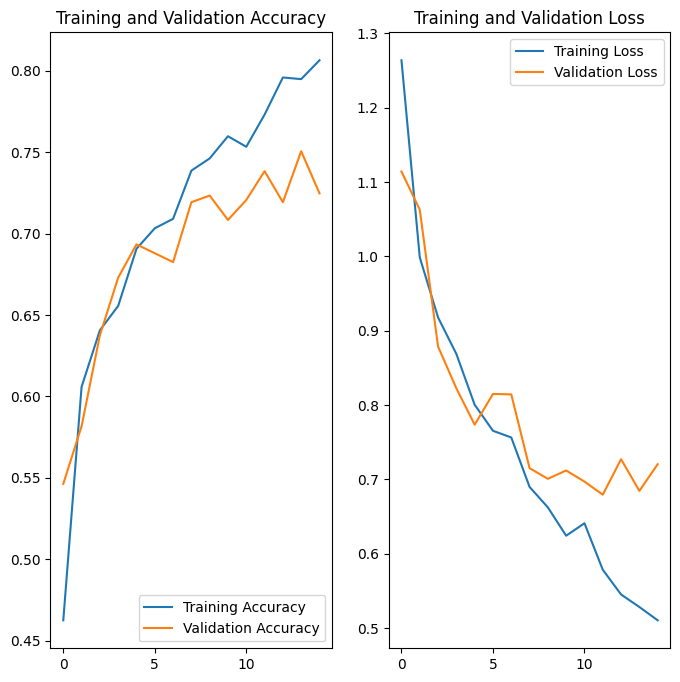

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


  8192/117948 [=>............................] - ETA: 0s


117948/117948 [==============================] - 0s 0us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 132ms/step


This image most likely belongs to sunflowers with a 65.93 percent confidence.


## Use TensorFlow Lite




### Convert the Keras Sequential model to a TensorFlow Lite model


In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp1ci_e189/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp1ci_e189/assets


2023-07-27 06:07:32.903869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-27 06:07:32.903908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


### Run the TensorFlow Lite model



In [32]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [35]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [36]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 65.93 percent confidence.


In [37]:
print(np.max(np.abs(predictions - predictions_lite)))

2.1457672e-06
